## Importando bibliotecas

In [1]:
!pip install phik > /dev/null & echo 'Library Phi K Installed'
!pip install xgboost > /dev/null & echo 'Library XGBoost Installed'

Library Phi K Installed
Library XGBoost Installed


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import phik
import matplotlib.pyplot as plt
import phik
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Fazendo carga da base de dados

In [4]:
df =  pd.read_csv('titanic.csv',index_col = 0)

## Análise de dados

### Verificação de nulos

In [5]:
df.isnull().mean().sort_values(ascending=False)*100

Cabin       77.104377
Age         19.865320
Embarked     0.224467
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
dtype: float64

A coluna  Cabin tem um indice alto de nulos por esse motivo será removida.

In [6]:
df = df.drop('Cabin', axis = 1)

### Verificando multicolineariedade

In [7]:
df_phik = df.phik_matrix()

interval columns not set, guessing: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


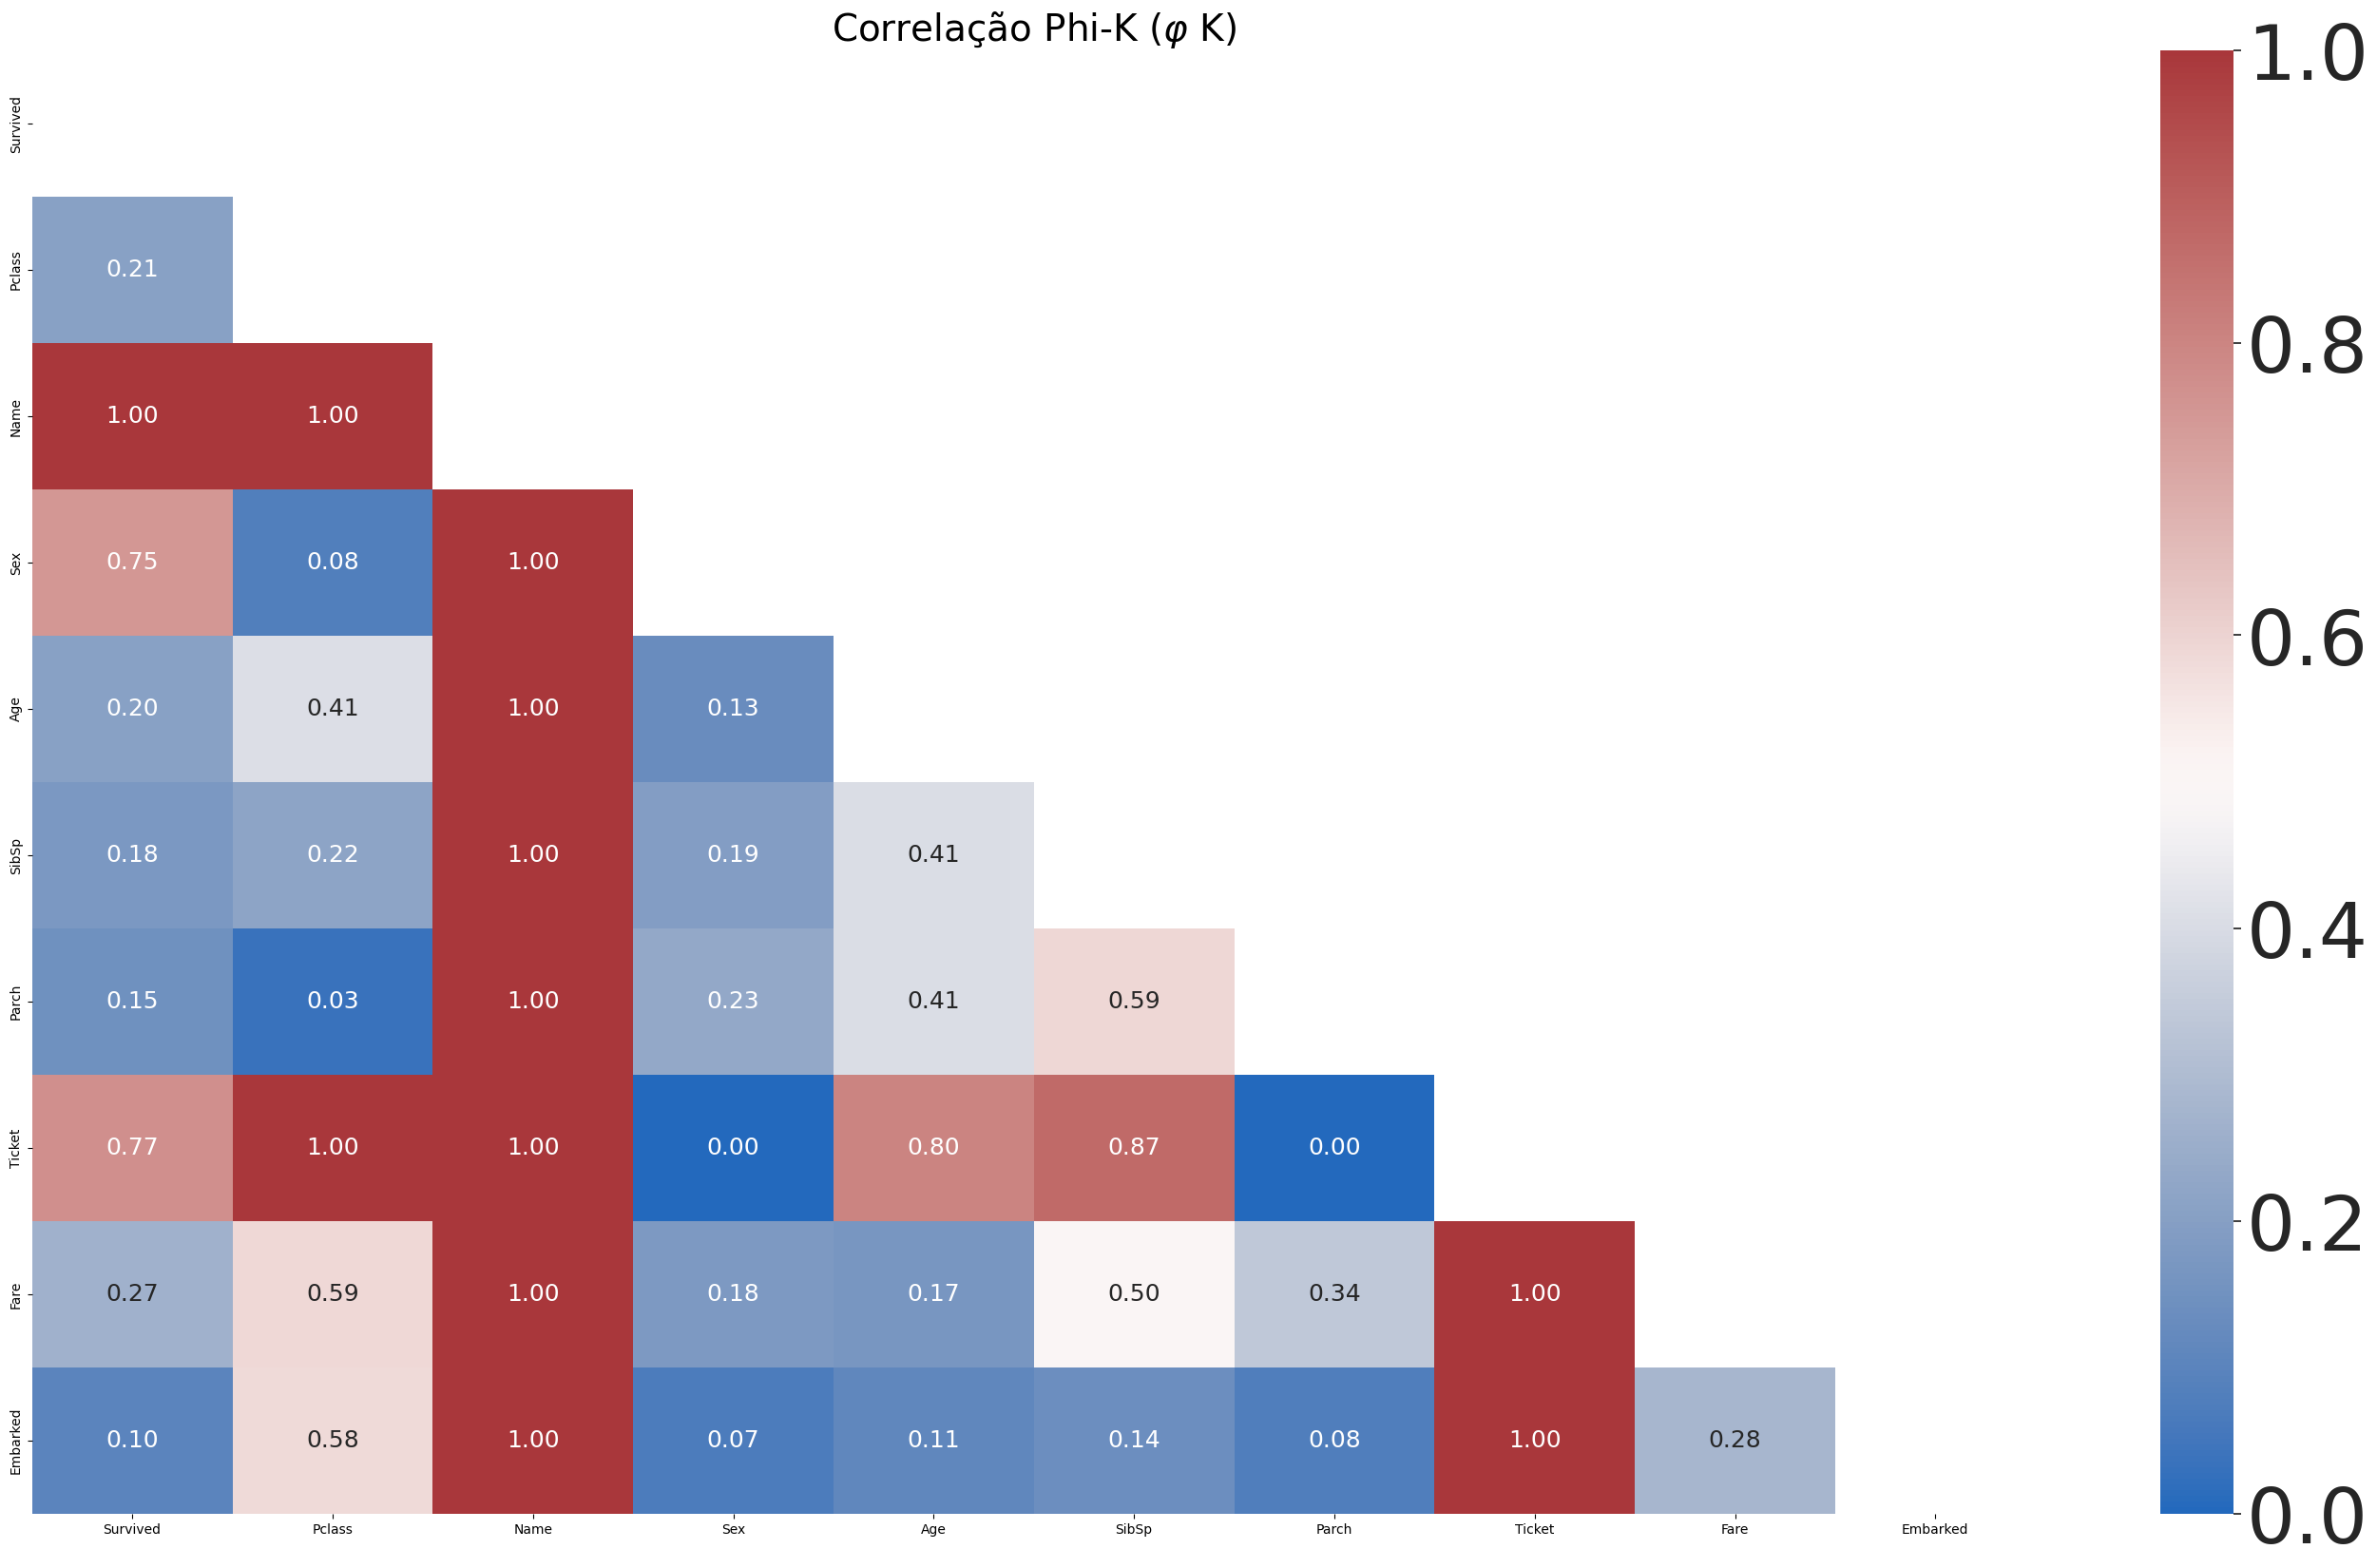

In [8]:
plt.figure(figsize=(34,20))
plt.title(r'Correlação Phi-K ($\varphi$ K)', fontsize=28)

# Construção de uma máscara
# Usando Booleanos pois o phi k vai de 0 a 1
# Com inteiros deu problema
mask = np.triu(np.ones_like(df_phik, dtype = bool))
sns.set(font_scale=1.5)
htm = sns.heatmap(df_phik, annot=True, mask = mask,
                  vmin=0, vmax=1, cmap='vlag',fmt='.2f',)

cbar = htm.collections[0].colorbar
cbar.ax.tick_params(labelsize = 58)

plt.savefig('triu.pdf')
plt.show()

Podemos observar que as colunas 'Ticket' e 'Name' tem uma correlção alta com muitas características por esse motivo vamos remover.  
Sendo asism prejudicando a variabilidade dos dados.

In [9]:
# retirando colunas com nome, ingresso e cabine dos conjuntos
df.drop(["Name", "Ticket"] , axis=1, inplace=True)# Fare

In [10]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

## Pipeline

In [11]:
# pipeline para pré-processamento das variáveis Age e Fare
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [12]:
# pipeline para pré-processamento das variáveis Sex e Embarked
cat_transformer = Pipeline(steps=[
    ('one-hot encoder', OneHotEncoder())
])

In [13]:
# Compondo os pré-processadores
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, ['Age', 'Fare']),
    ('cat', cat_transformer, ['Sex', 'Embarked'])
])

In [14]:
# Lista de métricas Para classificação
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
metric = []

In [19]:
# Decision tree
param_dt = {'criterion':['gini', 'entropy', 'log_loss'],
           'max_depth':[2,3,4,5,7],}

# Random Forest
params_rf = {'n_estimators':[100,150,200,250,300,700],
             'max_depth':[2,3,4,5,6,7,],
             'criterion':['gini', 'entropy', 'log_loss'],}

# XGBoost
params_xgb = {'n_estimators':[100,150,200,250,300],
             'max_depth':[2,3,4,5,6,7],
             'eta':[0.1,0.2,0.3,0.4,],}



models = [ (DecisionTreeClassifier(), param_dt, 'Decision Tree'),
           (RandomForestClassifier(), params_rf, 'Random Forest'),
           (XGBClassifier(),params_xgb,'XGboost')]


In [20]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']           
X_train, X_test,\
y_train, y_test = train_test_split(X, y,\
                  train_size = 0.7, random_state = 42)
cv = 7

In [27]:
df_result = pd.DataFrame()
classifier_list = []
for model_ in models:
    grid = GridSearchCV(model_[0], param_grid = model_[1], cv = cv,\
                        n_jobs = -1, scoring = 'accuracy')
    
    pipe =  Pipeline(steps=[
        ('preprocessor', preprocessor),
        (model_[2], grid)
    ])

    # treinando mo modelo
    pipe.fit(X_train,y_train)
    
    # Salvando resultados
    index = pipe[model_[2]].best_index_
    cv_results = pipe[model_[2]].cv_results_
    df_result[model_[2]] = [cv_results[f"split{i}_test_score"][index] for i in range(cv)]
    
    # Salvo para acessar o modelo desejado
    # criado pelo pipeline em caso de uso
    # em produção ou para uso de explicabilidade como o shap
    #classifier_list['Decision Tree'].best_estimator_
    #classifier_list.predict(X_test)
    classifier_list.append(pipe)
    
        

In [28]:
df_result

,Decision Tree,Random Forest,XGboost
0,0.730337,0.741573,0.741573
1,0.876404,0.876404,0.876404
2,0.842697,0.865169,0.853933
3,0.741573,0.730337,0.741573
4,0.786517,0.797753,0.853933
5,0.808989,0.752809,0.797753
6,0.865169,0.887640,0.898876


In [29]:
def boxplot_sorted(df, score, title, rot=90, figsize=(10,6), fontsize=12):
    df2 = df
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, fontsize=fontsize,
                                   boxprops=dict(linewidth=4, color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, color='firebrick'),
                                   capprops=dict(linewidth=4, color='cornflowerblue'),
                                   flierprops=dict(marker='o', markerfacecolor='dimgray',
                                        markersize=12, markeredgecolor='black'),
                                   return_type="axes")
    axes.set_title(title, fontsize=fontsize)
    plt.savefig(title + '.pdf')
    plt.show()

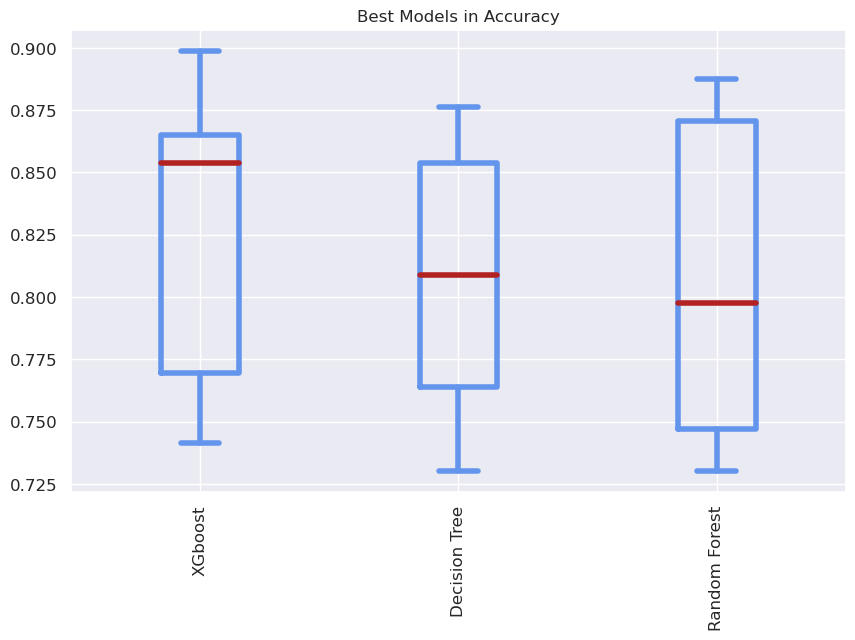

In [30]:
boxplot_sorted(df_result,'accuracy', 'Best Models in Accuracy')

In [42]:
for i in range(len(models)):
    print(models[i][2])
    print(classifier_list[i][models[i][2]].best_params_)


Decision Tree
{'criterion': 'entropy', 'max_depth': 7}
Random Forest
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
XGboost
{'eta': 0.1, 'max_depth': 4, 'n_estimators': 200}
